In [ ]:
pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 1.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357281 sha256=d98ade95666b805e4b7345943f5cc98b66fa8b7daa1dbfa0ee3c3c080b91f73f
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [ ]:
import pandas as pd
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split, GridSearchCV
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import accuracy

In [ ]:
data=pd.read_csv('/content/walmart.csv')

In [ ]:
data.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,7969


In [ ]:
data.select_dtypes(include='object').nunique()

,0
Product_ID,3631
Gender,2
Age,7
City_Category,3
Stay_In_Current_City_Years,5


In [ ]:
data.describe()

,User_ID,Occupation,Marital_Status,Product_Category,Purchase
count,5.500680e+05,550068.000000,550068.000000,550068.000000,550068.000000
mean,1.003029e+06,8.076707,0.409653,5.404270,9263.968713
std,1.727592e+03,6.522660,0.491770,3.936211,5023.065394
min,1.000001e+06,0.000000,0.000000,1.000000,12.000000
25%,1.001516e+06,2.000000,0.000000,1.000000,5823.000000
50%,1.003077e+06,7.000000,0.000000,5.000000,8047.000000
75%,1.004478e+06,14.000000,1.000000,8.000000,12054.000000
max,1.006040e+06,20.000000,1.000000,20.000000,23961.000000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   User_ID                     550068 non-null  int64 
 1   Product_ID                  550068 non-null  object
 2   Gender                      550068 non-null  object
 3   Age                         550068 non-null  object
 4   Occupation                  550068 non-null  int64 
 5   City_Category               550068 non-null  object
 6   Stay_In_Current_City_Years  550068 non-null  object
 7   Marital_Status              550068 non-null  int64 
 8   Product_Category            550068 non-null  int64 
 9   Purchase                    550068 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 42.0+ MB


In [ ]:
data.shape

(550068, 10)

In [ ]:
data.isnull().sum()

,0
User_ID,0
Product_ID,0
Gender,0
Age,0
Occupation,0
City_Category,0
Stay_In_Current_City_Years,0
Marital_Status,0
Product_Category,0
Purchase,0


In [ ]:
# Normalize the Purchase amounts
data['Purchase'] = (data['Purchase'] - data['Purchase'].mean()) / data['Purchase'].std()

# Prepare the data for the Surprise library
reader = Reader(rating_scale=(data['Purchase'].min(), data['Purchase'].max()))
data_surprise = Dataset.load_from_df(data[['User_ID', 'Product_ID', 'Purchase']], reader)

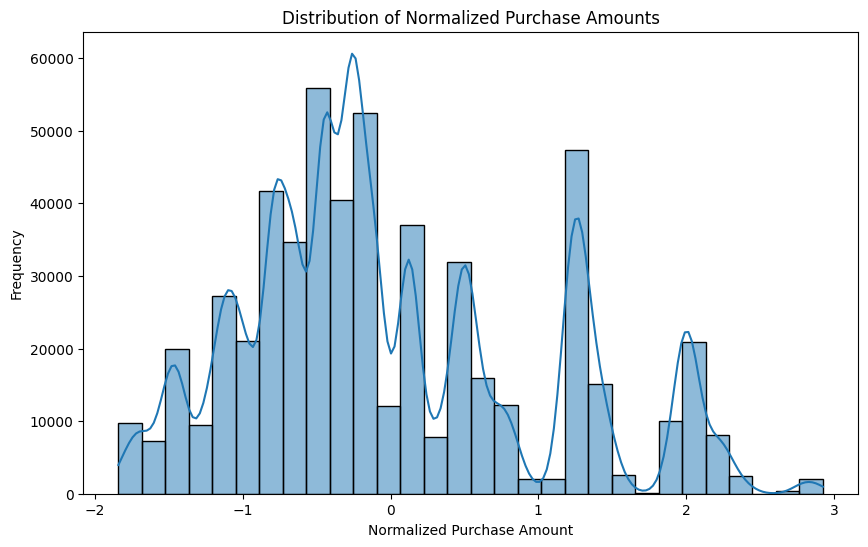

In [ ]:
# Plot the distribution of normalized purchase amounts
plt.figure(figsize=(10, 6))
sns.histplot(data['Purchase'], bins=30, kde=True)
plt.title('Distribution of Normalized Purchase Amounts')
plt.xlabel('Normalized Purchase Amount')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Hyperparameter tuning for the SVD algorithm with a higher number of factors
param_grid = {
    'n_factors': [100, 150],  # Increasing number of factors
    'n_epochs': [30, 40],     # More epochs to allow for better training
    'lr_all': [0.005, 0.01],
    'reg_all': [0.02, 0.1]
}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data_surprise)

# Get the best parameters and use them to train the model
best_algo = gs.best_estimator['rmse']

In [ ]:
# Train-test split
trainset, testset = train_test_split(data_surprise, test_size=0.25)
best_algo.fit(trainset)

# Evaluate the model
predictions = best_algo.test(testset)
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

RMSE: 0.5005
MAE:  0.3737


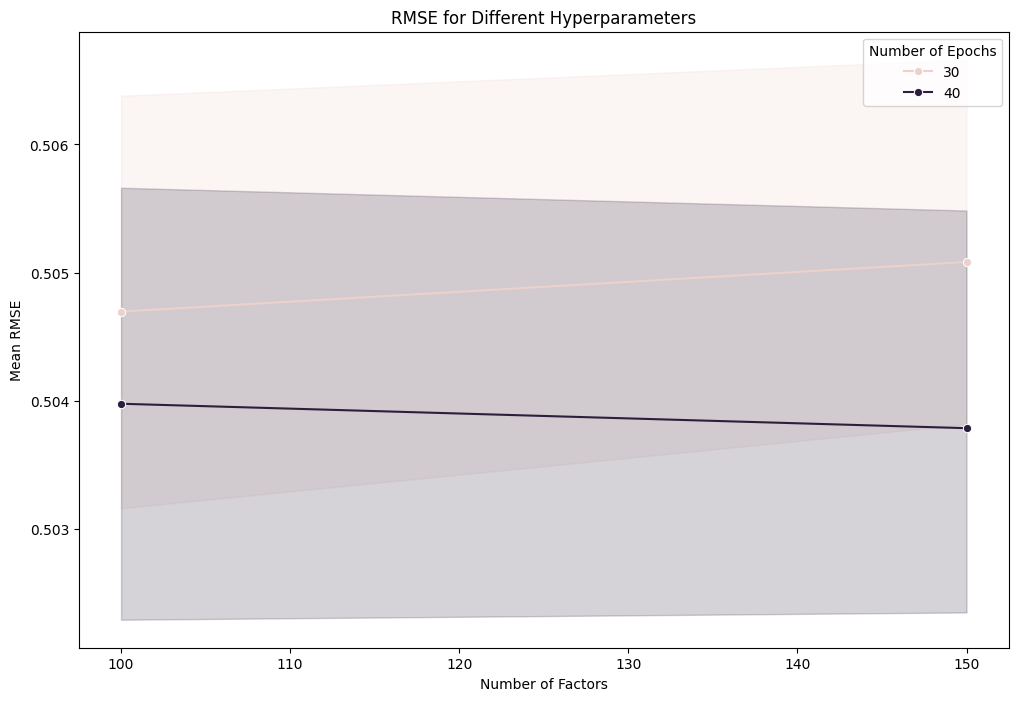

In [ ]:
# Plot RMSE for Grid Search results
results = pd.DataFrame(gs.cv_results)
plt.figure(figsize=(12, 8))
sns.lineplot(data=results, x='param_n_factors', y='mean_test_rmse', hue='param_n_epochs', marker='o')
plt.title('RMSE for Different Hyperparameters')
plt.xlabel('Number of Factors')
plt.ylabel('Mean RMSE')
plt.legend(title='Number of Epochs')
plt.show()

In [ ]:
# Function to recommend top N products for a given user
def recommend_products(user_id, n=5):
    # Check if the user exists in the dataset
    if user_id not in data['User_ID'].unique():
        print(f"User ID {user_id} not found in the dataset. Returning popular items as a recommendation.")

        # Recommend the top N popular products based on average purchase value
        popular_products = data.groupby('Product_ID')['Purchase'].mean().sort_values(ascending=False).head(n)
        return list(popular_products.index), list(popular_products.values)

    # Get the list of all product IDs
    all_product_ids = data['Product_ID'].unique()

    # Get the products the user has already interacted with
    user_data = data[data['User_ID'] == user_id]
    user_product_ids = set(user_data['Product_ID'].unique())

    # Create a list to store the predictions
    predictions = []

    # Predict the purchase amount for all products the user hasn't interacted with
    for product_id in all_product_ids:
        if product_id not in user_product_ids:
            pred = best_algo.predict(user_id, product_id)
            predictions.append((product_id, pred.est))

    # Sort the predictions by estimated purchase amount
    predictions.sort(key=lambda x: x[1], reverse=True)

    # Return the top N product recommendations
    top_n_products = predictions[:n]
    return top_n_products


In [ ]:
# Example: Recommend top 5 products for an existing user
user_id = 1000001
top_products_user_1 = recommend_products(user_id, n=5)

# Display the recommended products for user 1000001
print("Recommendations for user 1000001:", top_products_user_1)

Recommendations for user 1000001: [('P00086242', 2.1879669152701395), ('P00085342', 2.1861267921176695), ('P00200642', 2.079982323526861), ('P00119342', 2.0618797979689476), ('P00116142', 2.0419680323665492)]


In [ ]:
# Example: Recommend top 5 products for another existing user
user_id = 1000005
top_products_user_2 = recommend_products(user_id, n=5)

# Display the recommended products for user 1000005
print("Recommendations for user 1000005:", top_products_user_2)

Recommendations for user 1000005: [('P00086242', 1.855310900046898), ('P00085342', 1.8206613744667717), ('P00119342', 1.71745484468214), ('P00200642', 1.715962733717987), ('P00117642', 1.669228349384853)]


In [ ]:
# Example: Recommend top 5 products for another existing user
user_id = -1
top_products_user_2 = recommend_products(user_id, n=5)

# Display the recommended products for user 1000005
print("Recommendations for user 1000005:", top_products_user_2)

User ID -1 not found in the dataset. Returning popular items as a recommendation.
Recommendations for user 1000005: (['P00086242', 'P00085342', 'P00200642', 'P00116142', 'P00119342'], [2.3874936600068337, 2.332499874956116, 2.230670644866751, 2.2296788288039324, 2.226685679686151])


In [ ]:
from surprise import dump

# Save the Surprise model using dump.dump()
dump.dump('recommendation_model', algo=best_algo)

# To load the model later, use dump.load()
_, loaded_algo = dump.load('recommendation_model')